In [1]:
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import scipy as sp

In [2]:
#opens .dat files to be converted into CSVs
#change pathprefix on different computers
pathprefix = "/home/tplohr/proj/SF 24-25/diettim NMMA master EOS-chiralEFT_MTOV/"

def loadfile(number):
    file = open(pathprefix + str(number) + '.dat', 'r')
    return file

In [3]:
#creates an empty array to contain all EOSs 
numofEOS = 5000
EOSs = [None] * numofEOS

#fills "EOSs" with arrays of each EOS's mass and radius values 
for i in range(numofEOS):
    df = pd.read_csv(loadfile(i+1), delimiter = '\t', names = ["radius", "mass", "deformability"])
    EOSs[i] = np.array([df["radius"], df["mass"]])
#EOSs[i] is EOS_i
#EOSs[i][0] is the list of radius values of EOS_i
#EOSs[i][1] is the list of mass values of EOS_i
#EOSs[i][0][j] is the radius value indexed j of EOS_i
#EOSs[i][1][j] is the mass value indexed j of EOS_i

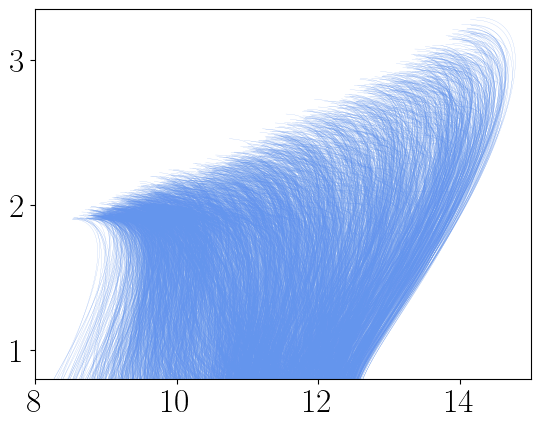

In [4]:
#plots each EOS 
for i in range(numofEOS):
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.rcParams['figure.figsize'] = [8,3]
    plt.plot(EOSs[i][0], EOSs[i][1], 'cornflowerblue', linewidth=.1)

In [5]:
#standard deviation and mean for the radius
sigma_r = 0.8
mu_r = 11.8
#standard deviation and mean for the mass
sigma_m = 0.2
mu_m = 1.4

In [6]:
def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

In [7]:
#initialization of probability arrays

#probabilities of the EOSs given the observations, each index corresponds to one EOS; posterior
P_EOS_given_obs = np.zeros(numofEOS)
#probabilities of the observations given an EOS; likelihood
P_obs_given_EOS = np.zeros(numofEOS)
#probabilities of the EOSs without a condition; prior
P_EOS = np.ones(numofEOS)/numofEOS

In [8]:
#calculate the probability of the observations given an EOS; likelihood
num_points = 1000
def calc_P_obs_given_EOS(i):
    #m is the interpolated function m(r)
    m = sp.interpolate.interp1d(EOSs[i][0], EOSs[i][1])
    
    #various radius related values for calculated the derivative of m(r) (m_prime)
    min_r = np.min(EOSs[i][0])
    max_r = np.max(EOSs[i][0])
    len_r = max_r-min_r
    #important to note that num_points is set not delta_r rather that vice versa
    delta_r = len_r/(num_points-1)
    #r is an array of all the radius values to sum over, the last point is removed since the forward euler derivative DNE
    r = np.linspace(min_r, max_r-delta_r, num_points-1)
    
    P = 0
    #loop over each radius value space by delta_r
    for j in range(len(r)):
        #m_prime is the forward euler derivative of m(r)
        m_prime = (m(r[j]+delta_r) - m(r[j]))/delta_r
        
        #delta_l is the length between two points along the curve
        delta_l = np.sqrt(1 + m_prime**2)*delta_r
        #probability of the mass-radius point
        pdf_value = gaussian(r[j], mu_r, sigma_r) * gaussian(m(r[j]), mu_m, sigma_m)
        
        #probability of EOS_i is the sum of the probability of each point multiplied by the distance to the next point
        P += pdf_value*delta_l
    return P

In [9]:
norm_factor = 0
for i in range(numofEOS):
    #calculate the likelihood
    P_obs_given_EOS[i] = calc_P_obs_given_EOS(i)
    #calculate the denominator (sum of the numerator)
    norm_factor += P_obs_given_EOS[i]

for i in range(numofEOS):
    #calculate the posterior
    P_EOS_given_obs[i] = P_obs_given_EOS[i] / norm_factor

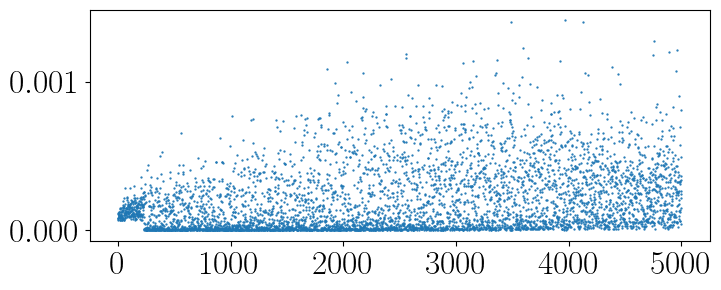

In [10]:
plt.scatter(np.linspace(0,numofEOS,5000), P_EOS_given_obs, s=0.4)

In [11]:
tot_prob = 0
for i in range(numofEOS):
    tot_prob += P_EOS_given_obs[i]
print(tot_prob)

0.9999999999999977


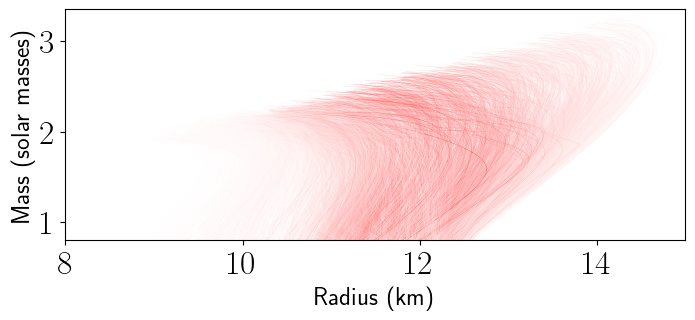

In [12]:
#plotting each EOS; low probability is white, high probability is red
cmap = mp.colors.LinearSegmentedColormap.from_list("white_to_red", ["white","red"])
norm = plt.Normalize(P_EOS_given_obs.min(), P_EOS_given_obs.max())
#plots each EOS 
for i in range(numofEOS):
    color = cmap(norm(P_EOS_given_obs[i]))
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.rcParams['figure.figsize'] = [9,5]
    plt.plot(EOSs[i][0], EOSs[i][1], color=color, linewidth=.1)

In [13]:
print(P_EOS_given_obs)

[8.20927864e-05 6.87629032e-05 1.07355338e-04 ... 1.47890572e-04
 2.17106739e-04 3.67937572e-04]
